In [ ]:
#@test {"skip": true}
!pip install --quiet --upgrade dp-accounting
!pip install --quiet --upgrade tensorflow-federated

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.5/103.5 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.7/126.7 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.6/532.6 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 9.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
arviz 0.15.1 requires scipy>=1.8.0, but you have scipy 1.7.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 558.5/558.5 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 

In [ ]:
# import Tensorflow library and all necessary modules 
# https://github.com/tensorflow/federated/blob/v0.58.0/tensorflow_federated/__init__.py
import collections

import dp_accounting
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_federated as tff
import tensorflow_privacy as tfp
from tensorflow.keras import layers

In [ ]:
def flip_labels(example, num_classes, flip_probability=0.3): #randomly generates an integer between 0 and 'num_classes
    flipped_label = np.random.randint(0, num_classes)
    return tf.cond(tf.random.uniform(()) < flip_probability, lambda: flipped_label, lambda: example['label'])
    #the result of the tf.cond operation is returned as the output of the flip_labels function, lambda fun verifies and return True if labels_flipped and false or else
# loading the emnist data
def get_emnist_dataset():
    emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data(
        only_digits=True)

    def element_fn(element, flip_probability):
        return collections.OrderedDict(
            x=tf.expand_dims(element['pixels'], -1), y=flip_labels(element, 10, flip_probability))

    def preprocess_train_dataset(dataset, flip_probability=0.3): #preprocess_train_dataset func applies mapping, shuffling, repetition, and batching operations to the input dataset
        return (dataset.map(lambda x: element_fn(x, flip_probability))
                       .shuffle(buffer_size=418)  #shuffle func shuffles the elements of the dataset using a buffer size of 418
                       .repeat(1)
                       .batch(32, drop_remainder=False))

    def preprocess_test_dataset(dataset):
        return dataset.map(lambda x: element_fn(x, 0.0)).batch(128, drop_remainder=False)

    emnist_train = emnist_train.preprocess(lambda ds: preprocess_train_dataset(ds, 0.3))
    emnist_test = preprocess_test_dataset(
        emnist_test.create_tf_dataset_from_all_clients())
    return emnist_train, emnist_test

train_data, test_data = get_emnist_dataset()

In [ ]:
def my_model_fn():
  model = tf.keras.models.Sequential([ #creates a sequential model using tf.keras.models.Sequential
      tf.keras.layers.Reshape(input_shape=(28, 28, 1), target_shape=(28 * 28,)),
      tf.keras.layers.Dense(200, activation=tf.nn.relu),
      tf.keras.layers.Dense(200, activation=tf.nn.relu),
      tf.keras.layers.Dense(10)])
  return tff.learning.models.from_keras_model( #converts the created Keras model into a TFF-compatible model using the tff.learning.models.from_keras_model function
      keras_model=model,
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #defines the loss function to be used during training, it is the sparse categorical cross-entropy loss.
      input_spec=test_data.element_spec,
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [ ]:
total_clients = len(train_data.client_ids) #train that performs training in a federated learning setting with differential privacy (DP)

def train(rounds, noise_multiplier, clients_per_round, data_frame):
  aggregation_factory = tff.learning.model_update_aggregator.dp_aggregator(
      noise_multiplier, clients_per_round)

  # We use Poisson subsampling which gives slightly tighter privacy guarantees
  # compared to having a fixed number of clients per round. The actual number of
  # clients per round is stochastic with mean clients_per_round.
  sampling_prob = clients_per_round / total_clients #clients_per_round represents the expected number of clients to participate in each round of training
   #total_clients represents the total number of clients available in the training dataset

  # Build a federated averaging process.
  # Typically a non-adaptive server optimizer is used because the noise in the
  # updates can cause the second moment accumulators to become very large
  learning_process = tff.learning.algorithms.build_unweighted_fed_avg(
        my_model_fn, #my_model_fn: The function that creates the TFF-compatible model used for training
        #client_optimizer_fn: A function that returns a client optimizer  
        #an instance of tf.keras.optimizers.SGD with a learning rate of 0.01
        client_optimizer_fn=lambda: tf.keras.optimizers.SGD(0.01),
        server_optimizer_fn=lambda: tf.keras.optimizers.SGD(1.0, momentum=0.9),
        model_aggregator=aggregation_factory)

  eval_process = tff.learning.build_federated_evaluation(my_model_fn) #build_federated_evaluation function from tff.learning
    
  # Training loop.
  state = learning_process.initialize()
  for round in range(rounds):
    if round % 5 == 0:
      model_weights = learning_process.get_model_weights(state) #retrieves the model weights from the current state of the learning process
      metrics = eval_process(model_weights, [test_data])['eval']
      if round < 25 or round % 25 == 0:
        print(f'Round {round:3d}: {metrics}')
      data_frame = data_frame.append({'Round': round,
                                      'NoiseMultiplier': noise_multiplier,
                                      **metrics}, ignore_index=True) #stores the metrics obtained from the federated learning update in the metrics variable

    x = np.random.uniform(size=total_clients)
    sampled_clients = [
        train_data.client_ids[i] for i in range(total_clients)
        if x[i] < sampling_prob]
    sampled_train_data = [
        train_data.create_tf_dataset_for_client(client)
        for client in sampled_clients]

    # Use selected clients for update.
    result = learning_process.next(state, sampled_train_data)
    state = result.state
    metrics = result.metrics

  model_weights = learning_process.get_model_weights(state)
  metrics = eval_process(model_weights, [test_data])['eval']
  print(f'Round {rounds:3d}: {metrics}')
  data_frame = data_frame.append({'Round': rounds,
                                  'NoiseMultiplier': noise_multiplier,
                                  **metrics}, ignore_index=True)

  return data_frame


In [ ]:
data_frame = pd.DataFrame()
rounds = 50
clients_per_round = 50

for noise_multiplier in [0.5, 0.75, 1.0]:
  print(f'Starting training with noise multiplier: {noise_multiplier}')
  data_frame = train(rounds, noise_multiplier, clients_per_round, data_frame)
  print()

Starting training with noise multiplier: 0.5


<ipython-input-6-261a4597242a>:24: DeprecationWarning: `tff.learning.build_federated_evaluation` is deprecated, use `tff.learning.algorithms.build_fed_eval` instead.
  eval_process = tff.learning.build_federated_evaluation(my_model_fn)


Round   0: OrderedDict([('sparse_categorical_accuracy', 0.09982367), ('loss', 2.6749387), ('num_examples', 40832), ('num_batches', 319)])


<ipython-input-6-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,


Round   5: OrderedDict([('sparse_categorical_accuracy', 0.11312206), ('loss', 2.2879596), ('num_examples', 40832), ('num_batches', 319)])


<ipython-input-6-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,


Round  10: OrderedDict([('sparse_categorical_accuracy', 0.10984032), ('loss', 2.242413), ('num_examples', 40832), ('num_batches', 319)])


<ipython-input-6-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,


Round  15: OrderedDict([('sparse_categorical_accuracy', 0.24201606), ('loss', 2.1432538), ('num_examples', 40832), ('num_batches', 319)])


<ipython-input-6-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,


Round  20: OrderedDict([('sparse_categorical_accuracy', 0.36084443), ('loss', 2.0403893), ('num_examples', 40832), ('num_batches', 319)])


<ipython-input-6-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,


Round  25: OrderedDict([('sparse_categorical_accuracy', 0.37188968), ('loss', 1.9352641), ('num_examples', 40832), ('num_batches', 319)])


<ipython-input-6-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,
<ipython-input-6-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,
<ipython-input-6-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,
<ipython-input-6-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,
<ipython-input-6-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

Round  50: OrderedDict([('sparse_categorical_accuracy', 0.65904194), ('loss', 1.223773), ('num_examples', 40832), ('num_batches', 319)])

Starting training with noise multiplier: 0.75


<ipython-input-6-261a4597242a>:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': rounds,
<ipython-input-6-261a4597242a>:24: DeprecationWarning: `tff.learning.build_federated_evaluation` is deprecated, use `tff.learning.algorithms.build_fed_eval` instead.
  eval_process = tff.learning.build_federated_evaluation(my_model_fn)


Round   0: OrderedDict([('sparse_categorical_accuracy', 0.105481), ('loss', 2.674523), ('num_examples', 40832), ('num_batches', 319)])


<ipython-input-6-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,


Round   5: OrderedDict([('sparse_categorical_accuracy', 0.14221689), ('loss', 2.281603), ('num_examples', 40832), ('num_batches', 319)])


<ipython-input-6-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,


Round  10: OrderedDict([('sparse_categorical_accuracy', 0.19310835), ('loss', 2.2142828), ('num_examples', 40832), ('num_batches', 319)])


<ipython-input-6-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,


Round  15: OrderedDict([('sparse_categorical_accuracy', 0.31671238), ('loss', 2.09216), ('num_examples', 40832), ('num_batches', 319)])


<ipython-input-6-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,


Round  20: OrderedDict([('sparse_categorical_accuracy', 0.41910756), ('loss', 1.9447451), ('num_examples', 40832), ('num_batches', 319)])


<ipython-input-6-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,


Round  25: OrderedDict([('sparse_categorical_accuracy', 0.5258376), ('loss', 1.7941805), ('num_examples', 40832), ('num_batches', 319)])


<ipython-input-6-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,
<ipython-input-6-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,
<ipython-input-6-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,
<ipython-input-6-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,
<ipython-input-6-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

Round  50: OrderedDict([('sparse_categorical_accuracy', 0.6765772), ('loss', 1.2186219), ('num_examples', 40832), ('num_batches', 319)])

Starting training with noise multiplier: 1.0


<ipython-input-6-261a4597242a>:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': rounds,
<ipython-input-6-261a4597242a>:24: DeprecationWarning: `tff.learning.build_federated_evaluation` is deprecated, use `tff.learning.algorithms.build_fed_eval` instead.
  eval_process = tff.learning.build_federated_evaluation(my_model_fn)


Round   0: OrderedDict([('sparse_categorical_accuracy', 0.09495004), ('loss', 2.5042238), ('num_examples', 40832), ('num_batches', 319)])


<ipython-input-6-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,


Round   5: OrderedDict([('sparse_categorical_accuracy', 0.19621865), ('loss', 2.2656353), ('num_examples', 40832), ('num_batches', 319)])


<ipython-input-6-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,


Round  10: OrderedDict([('sparse_categorical_accuracy', 0.24517535), ('loss', 2.2240386), ('num_examples', 40832), ('num_batches', 319)])


<ipython-input-6-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,


Round  15: OrderedDict([('sparse_categorical_accuracy', 0.1679565), ('loss', 2.1871424), ('num_examples', 40832), ('num_batches', 319)])


<ipython-input-6-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,


Round  20: OrderedDict([('sparse_categorical_accuracy', 0.43767142), ('loss', 1.9376018), ('num_examples', 40832), ('num_batches', 319)])


<ipython-input-6-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,


Round  25: OrderedDict([('sparse_categorical_accuracy', 0.35300744), ('loss', 1.8773414), ('num_examples', 40832), ('num_batches', 319)])


<ipython-input-6-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,
<ipython-input-6-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,
<ipython-input-6-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,
<ipython-input-6-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,
<ipython-input-6-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

Round  50: OrderedDict([('sparse_categorical_accuracy', 0.5297316), ('loss', 1.4346999), ('num_examples', 40832), ('num_batches', 319)])



<ipython-input-6-261a4597242a>:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': rounds,


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def make_plot(data_frame):
  plt.figure(figsize=(15, 5))

  dff = data_frame.rename(
      columns={'sparse_categorical_accuracy': 'Accuracy', 'loss': 'Loss'}) #renames the columns of the DataFrame (data_frame) to 'Accuracy' and 'Loss', It creates a new DataFrame dff with the renamed columns for plotting

  plt.subplot(121)
  sns.lineplot(data=dff, x='Round', y='Accuracy', hue='NoiseMultiplier', palette='dark') #number of rounds, noise_multiplier, clients_per_round, data_frames being considered
  plt.subplot(122)
  sns.lineplot(data=dff, x='Round', y='Loss', hue='NoiseMultiplier', palette='dark')

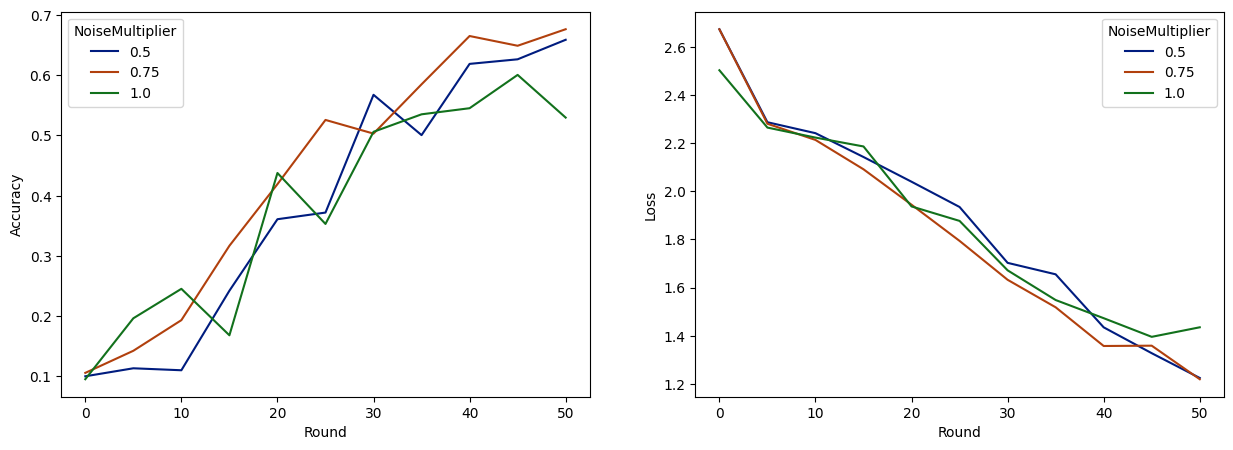

In [ ]:
make_plot(data_frame)

In [ ]:
total_clients = 3383
noise_to_clients_ratio = 0.01
target_delta = 1e-5
target_eps = 2

# Initialize arguments to dp_accounting.calibrate_dp_mechanism.
# No-arg callable that returns a fresh accountant.
make_fresh_accountant = dp_accounting.rdp.RdpAccountant

# Create function that takes expected clients per round and returns a 
# dp_accounting.DpEvent representing the full training process.
def make_event_from_param(clients_per_round):
  q = clients_per_round / total_clients
  noise_multiplier = clients_per_round * noise_to_clients_ratio
  gaussian_event = dp_accounting.GaussianDpEvent(noise_multiplier)
  sampled_event = dp_accounting.PoissonSampledDpEvent(q, gaussian_event)
  composed_event = dp_accounting.SelfComposedDpEvent(sampled_event, rounds)
  return composed_event

# Create object representing the search range [1, 3383].
bracket_interval = dp_accounting.ExplicitBracketInterval(1, total_clients)

# Perform search for smallest clients_per_round achieving the target privacy.
clients_per_round = dp_accounting.calibrate_dp_mechanism(
    make_fresh_accountant, make_event_from_param, target_eps, target_delta,
    bracket_interval, discrete=True
)

noise_multiplier = clients_per_round * noise_to_clients_ratio
print(f'To get ({target_eps}, {target_delta})-DP, use {clients_per_round} '
      f'clients with noise multiplier {noise_multiplier}.')

To get (2, 1e-05)-DP, use 103 clients with noise multiplier 1.03.


<ipython-input-6-261a4597242a>:24: DeprecationWarning: `tff.learning.build_federated_evaluation` is deprecated, use `tff.learning.algorithms.build_fed_eval` instead.
  eval_process = tff.learning.build_federated_evaluation(my_model_fn)


Round   0: OrderedDict([('sparse_categorical_accuracy', 0.09982367), ('loss', 2.6276193), ('num_examples', 40832), ('num_batches', 319)])


<ipython-input-6-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,


Round   5: OrderedDict([('sparse_categorical_accuracy', 0.14500882), ('loss', 2.2904086), ('num_examples', 40832), ('num_batches', 319)])


<ipython-input-6-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,


Round  10: OrderedDict([('sparse_categorical_accuracy', 0.25756758), ('loss', 2.2179868), ('num_examples', 40832), ('num_batches', 319)])


<ipython-input-6-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,


Round  15: OrderedDict([('sparse_categorical_accuracy', 0.17052802), ('loss', 2.2183654), ('num_examples', 40832), ('num_batches', 319)])


<ipython-input-6-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,


Round  20: OrderedDict([('sparse_categorical_accuracy', 0.33170062), ('loss', 2.0304313), ('num_examples', 40832), ('num_batches', 319)])


<ipython-input-6-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,


Round  25: OrderedDict([('sparse_categorical_accuracy', 0.31450823), ('loss', 1.9374617), ('num_examples', 40832), ('num_batches', 319)])


<ipython-input-6-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,
<ipython-input-6-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,
<ipython-input-6-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,
<ipython-input-6-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,
<ipython-input-6-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

Round  50: OrderedDict([('sparse_categorical_accuracy', 0.42949158), ('loss', 1.7073106), ('num_examples', 40832), ('num_batches', 319)])


<ipython-input-6-261a4597242a>:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': rounds,


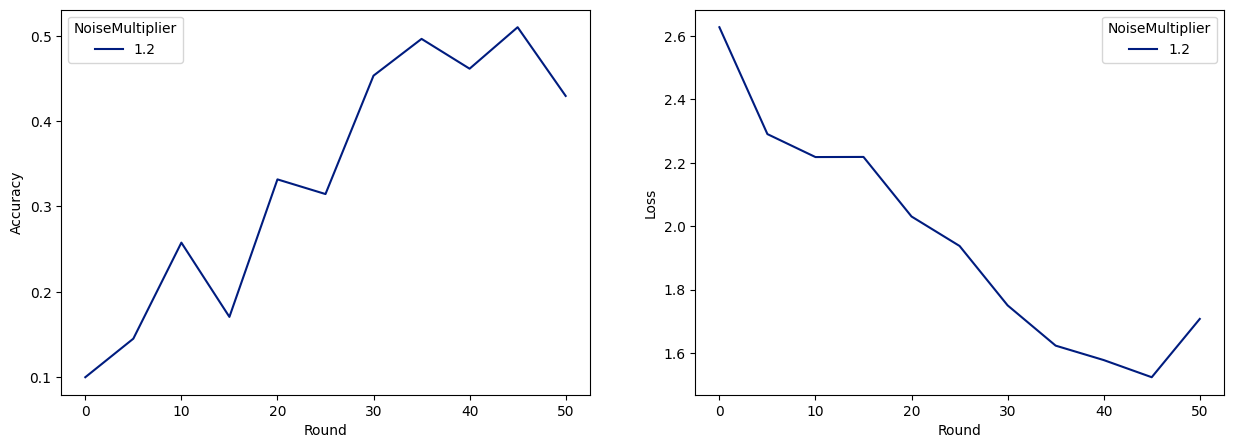

In [ ]:
rounds = 50
noise_multiplier = 1.2
clients_per_round = 50

data_frame = pd.DataFrame()
data_frame = train(rounds, noise_multiplier, clients_per_round, data_frame)

make_plot(data_frame)